In [ ]:
import argparse
import json
import pickle
import time
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import unquote

import requests
from kilt.knowledge_source import KnowledgeSource
from tqdm.auto import tqdm, trange
from datetime import date, timedelta, datetime
import requests
import gzip

In [ ]:
def get_response(url):
    try:
        res = requests.get(url)
        res = gzip.decompress(res.content).decode("utf-8")
        res = [line.split(" ") for line in res.split("\n")]
        res = {line[1]: line[2] for line in res if line[0] == "en"}
    except:
        print(url)
    return res

In [ ]:
num_threads = 4
with ThreadPoolExecutor(max_workers=num_threads) as executor:

    start_date = datetime(2019, 1, 1, 0, 0)
    end_date = datetime(2019, 1, 2, 0, 0)
    delta = timedelta(hours=1)
    futures = {}
    while start_date <= end_date:
        url = "https://dumps.wikimedia.org/other/pageviews/2019/{}/pageviews-{}.gz".format(
            start_date.strftime("%Y-%m"), start_date.strftime("%Y%m%d-%H%M%S")
        )
        futures[executor.submit(get_response, url)] = start_date
        start_date += delta

    iter_ = tqdm(as_completed(futures), total=len(futures), smoothing=0)
    results = {futures[future]: future.result() for future in iter_}

In [ ]:
import torch

In [ ]:
start_date = datetime(2018, 9, 1, 0, 0)
end_date = datetime(2018, 11, 1, 0, 0)
commands = []
while start_date <= end_date:
    commands.append(
        "wget https://dumps.wikimedia.org/other/pageviews/{}/{}/pageviews-{}.gz\n".format(
            start_date.strftime("%Y"), start_date.strftime("%Y-%m"), start_date.strftime("%Y%m%d-%H%M%S")
        )
    )
    start_date += timedelta(hours=torch.randint(1, 48, ()).item())

In [ ]:
with open("../pageviews/get.sh", "w") as f:
    f.writelines(commands)

In [ ]:
len(os.listdir("../pageviews"))

In [ ]:
import os

In [ ]:
all_stats = defaultdict(int)
for e in tqdm(os.listdir("../pageviews")):
    if ".gz" in e:
        
        with gzip.open('../pageviews/{}'.format(e), 'rb') as f:
            res = f.read().decode("utf-8")
        
        res = [line.split(" ") for line in res.split("\n")]
        res = {line[1]: line[2] for line in res if line[0] == "en"}
        
        for k, v in res.items():
            all_stats[k] += int(v)

In [ ]:
with open("../pageviews/all_stats.pkl", "wb") as f:
    pickle.dump(all_stats, f)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
all_stats_list = sorted(all_stats.items(), key=lambda x: x[1], reverse=True)

In [ ]:
plt.plot([math.log(e[1]) for e in all_stats_list[::-1]][:100000])

In [ ]:
kilt_stats = {}
for k in tqdm(title_id.keys()):
    kilt_stats[k] = all_stats.get(k.replace(" ", "_"), None)

In [ ]:
all_stats_list_filtered = [
    e for e in tqdm(all_stats_list[2:]) if all(a not in e[0] for a in (
        "Special:", "User:", "File:", "Help:", "Portal:", "Wikipedia:",
        "Template:", "Wikipedia_talk:", "Category:", "Template_talk:", "Talk:"
    ))
]

In [ ]:
top100k = set(e[0] for e in all_stats_list_filtered[:2000000])

In [ ]:
[e for e in list(top100k)[:100000] if ":" in e]

In [ ]:
with jsonlines.open("/private/home/ndecao/KILT/data/nq-dev-kilt.jsonl") as f:
    dataset = [e for e in f]

In [ ]:
found = [bool(top100k.intersection(set(p["title"].replace(" ", "_") 
     for o in d["output"] if "provenance" in o for p in o["provenance"])))
for d in tqdm(dataset)]

In [ ]:
sum(found) / len(found)

In [ ]:
import csv
with open("/private/home/egrave/efficientqa/data/wiki2018/passages_filter_overlap_list.tsv") as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t")
    passages_filter_overlap_list = [line for line in tqdm(tsvreader)]

In [ ]:
passages_filter_overlap_dict = defaultdict(list)

for e in tqdm(passages_filter_overlap_list):
    passages_filter_overlap_dict[e[-1]].append(e)

In [ ]:
len(passages_filter_overlap_dict)

In [ ]:
start_len = len(passages_filter_overlap_dict)
end_len = int(start_len * 0.9)
while len(passages_filter_overlap_dict) > end_len:
    page, _ = all_stats_list_filtered.pop()
    if page.replace("_", " ")  in passages_filter_overlap_dict:
        del passages_filter_overlap_dict[page.replace("_", " ")]

In [ ]:
len(passages_filter_overlap_dict)

In [ ]:
passages_filter_overlap_list_new = [
    f for e in passages_filter_overlap_dict.values() for f in e
]

In [ ]:
len(passages_filter_overlap_list_new) / len(passages_filter_overlap_list)

In [ ]:
import csv
with open("/private/home/ndecao/passages_filter_overlap_list_new.tsv", "w") as tsvfile:
    tsvfile.writelines("\t".join(e) + "\n" for e in passages_filter_overlap_list_new)

In [14]:
import math
import json
import jsonlines
import pickle
from tqdm.auto import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
from genre import GENRE
from genre.trie import Trie
from genre.entity_linking import get_end_to_end_prefix_allowed_tokens_fn_fariseq

In [2]:
with open("/checkpoint/ndecao/GENRE/data/anchors/mention_entitiy_table.pkl", "rb") as f:
    mention_entitiy_table = pickle.load(f)

In [3]:
from collections import defaultdict

In [4]:
entitiy_mention_table = defaultdict(lambda: defaultdict(int))

In [5]:
for m, d in tqdm(mention_entitiy_table.items()):
    for e, c in d.items():
        entitiy_mention_table[e][m] += c

In [87]:
dataset_guess = []
dataset_gold = []
base = "/checkpoint/fabiopetroni/GENRE/checkpoint/all_kilt.bart_large.ls0.1.mt2048.uf1.mu200000.dr0.1.atdr0.1.actdr0.0.wd0.01.adam.beta9999.eps1e-08.clip0.1.lr3e-05.warm500.fp16.ngpu128/"
for d in tqdm(("nq", "fever", "triviaqa", "wow", "trex", "hotpotqa", "structured_zeroshot", "wned", "cweb", "aidayago2")):
    with jsonlines.open(base + "{}-dev-kilt.filtered_60.search-lenpen=1.jsonl".format(d)) as f:
        dataset_guess += [e for e in f]

    with jsonlines.open("/private/home/ndecao/KILT/data/{}-dev-kilt.jsonl".format(d)) as f:
        dataset_gold += [e for e in f]

In [88]:
model = (
    GENRE.from_pretrained("models/fairseq_entity_disambiguation_aidayago")
    .eval()
)

/private/home/ndecao/.conda/envs/genre37/lib/python3.7/site-packages/hydra/_internal/hydra.py:71: UserWarning: 
@hydra.main(strict) flag is deprecated and will removed in the next version.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/strict_mode_flag_deprecated
  warnings.warn(message=msg, category=UserWarning)


In [89]:
stats = []
for dp, dg in zip(tqdm(dataset_guess), dataset_gold):
    lens = [len(model.encode(e)) for e in set(p["title"] for o in dg["output"] if "provenance" in o for p in o["provenance"])]
    stats.append((
        dp["output"][0]["provenance"][0]["title"] in [p["title"] for o in dg["output"] if "provenance" in o for p in o["provenance"]],
        sum(lens) / len(lens)
    ))

In [90]:
nstats = []
for i in range(1, int(max(e[1] for e in stats)) + 1):
    l = [e[0] for e in stats if (i !=0 and e[1] != 0 and i <= e[1] < i + 1) or (i == 0 and e[1] == 0)]
    nstats.append([i, np.mean(l), len(l)])

/private/home/ndecao/.conda/envs/genre37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/private/home/ndecao/.conda/envs/genre37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [91]:
nstats = nstats[2:18]

/private/home/ndecao/.conda/envs/genre37/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


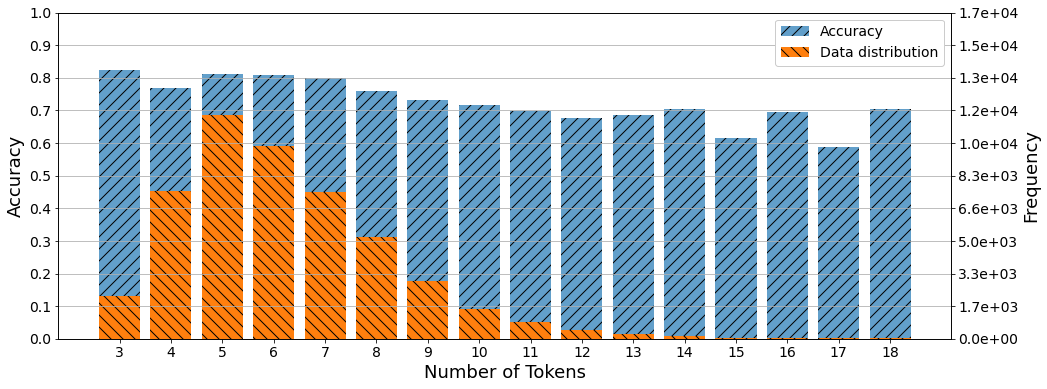

In [92]:
fig=plt.figure(figsize=(16, 6))
plt.grid(axis="y")
figure=fig.add_subplot(111)
figure.bar(
    range(len(nstats)),
    [e[1] for e in nstats],
    alpha=0.7,
    hatch="//",
    label="Accuracy"
)
figure.bar(
    range(len(nstats)),
    3 * np.array([e[2] for e in nstats]) / sum(e[2] for e in nstats),
    alpha=1,
    hatch="\\\\",
    label="Data distribution"
)
plt.xlabel("Number of Tokens", fontsize=18)

plt.yticks(np.linspace(0, 1, 11), fontsize=14)
plt.xticks(range(len(nstats)), [e[0] for e in nstats], fontsize=14)
plt.legend(fontsize=14, framealpha=1)
figure.set_ylabel("Accuracy", fontsize=18)

y1, y2=figure.get_ylim()
x1, x2=figure.get_xlim()
ax2=figure.twinx()
ax2.set_ylim(y1, y2)
ax2.set_yticks(np.linspace(0, 1, 11))
ax2.set_yticklabels(["{:.1e}".format(e) for e in sum(e[2] for e in nstats) * np.linspace(0, 1, 11) / 3],
                    fontsize=14)
ax2.set_ylabel('Frequency', fontsize=18)

plt.savefig("kilt_el_token_stats.pdf", bbox_inches='tight', pad_inches=0)

In [93]:
stats = []
for dp, dg in zip(tqdm(dataset_guess), dataset_gold):
    stats.append((
        dp["output"][0]["provenance"][0]["title"] in [
            p["title"] for o in dg["output"] if "provenance" in o for p in o["provenance"]
        ],
        sum(entitiy_mention_table[dp["output"][0]["provenance"][0]["title"]].values())
    ))

In [94]:
nstats = []
for i in range(-1, math.ceil(math.log(max(e[1] for e in stats), 2))):
    l = [e[0] for e in stats
         if (i != -1 and e[1] != 0 and 2 ** i <= e[1] < 2 ** (i + 1)) or (i == -1 and e[1] == 0)]
    nstats.append([i, np.mean(l), len(l)])

/private/home/ndecao/.conda/envs/genre37/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


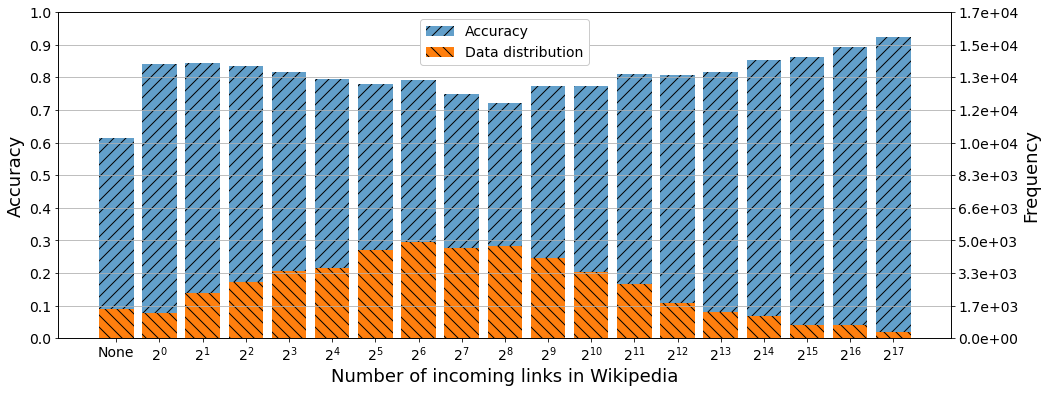

In [95]:
fig=plt.figure(figsize=(16, 6))
plt.grid(axis="y")
figure=fig.add_subplot(111)
figure.bar(
    range(len(nstats)),
    [e[1] for e in nstats],
    alpha=0.7,
    hatch="//",
    label="Accuracy"
)
figure.bar(
    range(len(nstats)),
    3 * np.array([e[2] for e in nstats]) / sum(e[2] for e in nstats),
    alpha=1,
    hatch="\\\\",
    label="Data distribution"
)
plt.xlabel("Number of incoming links in Wikipedia", fontsize=18)

plt.yticks(np.linspace(0, 1, 11), fontsize=14)
plt.xticks(range(len(nstats)), ["None"] + ["$2^{{{}}}$".format(e[0]) for e in nstats[1:]], fontsize=14)
plt.legend(fontsize=14, framealpha=1)
figure.set_ylabel("Accuracy", fontsize=18)

y1, y2=figure.get_ylim()
x1, x2=figure.get_xlim()
ax2=figure.twinx()
ax2.set_ylim(y1, y2)
ax2.set_yticks(np.linspace(0, 1, 11))
ax2.set_yticklabels(["{:.1e}".format(e) for e in sum(e[2] for e in nstats) * np.linspace(0, 1, 11) / 3],
                    fontsize=14)
ax2.set_ylabel('Frequency', fontsize=18)
plt.savefig("kilt_el_entity_stats.pdf", bbox_inches='tight', pad_inches=0)

In [98]:
sum(e[0] for e in stats) / len(stats)

0.7862492721029698

In [96]:
nstats

[[-1, 0.6125827814569537, 1510],
 [0, 0.8392036753445635, 1306],
 [1, 0.8423795049934868, 2303],
 [2, 0.8331020124913254, 2882],
 [3, 0.8168476665688289, 3407],
 [4, 0.794543429844098, 3592],
 [5, 0.778672032193159, 4473],
 [6, 0.7928075194115243, 4894],
 [7, 0.7477693144722525, 4595],
 [8, 0.7208413001912046, 4707],
 [9, 0.7720118052139695, 4066],
 [10, 0.7733610204687037, 3371],
 [11, 0.8088393819619116, 2783],
 [12, 0.8072687224669604, 1816],
 [13, 0.8173652694610778, 1336],
 [14, 0.85431654676259, 1112],
 [15, 0.8620689655172413, 667],
 [16, 0.8926470588235295, 680],
 [17, 0.9235880398671097, 301]]

In [76]:
dataset_guess = []
dataset_gold = []
base = "/checkpoint/fabiopetroni/GENRE/checkpoint/all_kilt.bart_large.ls0.1.mt2048.uf1.mu200000.dr0.1.atdr0.1.actdr0.0.wd0.01.adam.beta9999.eps1e-08.clip0.1.lr3e-05.warm500.fp16.ngpu128/"
for d in tqdm(("wned", "cweb", "aidayago2")):
    with jsonlines.open(base + "{}-dev-kilt.filtered_60.search-lenpen=1.jsonl".format(d)) as f:
        dataset_guess += [e for e in f]

    with jsonlines.open("/private/home/ndecao/KILT/data/{}-dev-kilt.jsonl".format(d)) as f:
        dataset_gold += [e for e in f]

In [77]:
stats = []
for dp, dg in zip(tqdm(dataset_guess), dataset_gold):
    stats.append((
        dp["output"][0]["provenance"][0]["title"] in [
            p["title"] for o in dg["output"] if "provenance" in o for p in o["provenance"]
        ],
        mention_entitiy_table.get(dg["meta"]["mention"].replace(" -- ", "–"), {}).get(
            dp["output"][0]["provenance"][0]["title"], 0
        )
    ))

In [78]:
nstats = []
for i in range(-1, math.ceil(math.log(max(e[1] for e in stats), 2))):
    l = [e[0] for e in stats
         if (i != -1 and e[1] != 0 and 2 ** i <= e[1] < 2 ** (i + 1)) or (i == -1 and e[1] == 0)]
    nstats.append([i, np.mean(l), len(l)])

/private/home/ndecao/.conda/envs/genre37/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


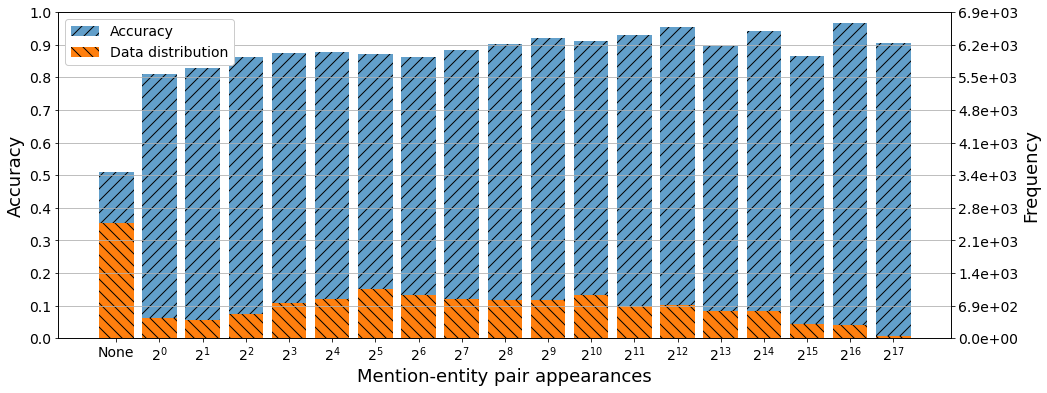

In [83]:
fig=plt.figure(figsize=(16, 6))
plt.grid(axis="y")
figure=fig.add_subplot(111)
figure.bar(
    range(len(nstats)),
    [e[1] for e in nstats],
    alpha=0.7,
    hatch="//",
    label="Accuracy"
)
figure.bar(
    range(len(nstats)),
    2 * np.array([e[2] for e in nstats]) / sum(e[2] for e in nstats),
    alpha=1,
    hatch="\\\\",
    label="Data distribution"
)
plt.xlabel("Mention-entity pair appearances", fontsize=18)

plt.yticks(np.linspace(0, 1, 11), fontsize=14)
plt.xticks(range(len(nstats)), ["None"] + ["$2^{{{}}}$".format(e[0]) for e in nstats[1:]], fontsize=14)
plt.legend(fontsize=14, framealpha=1)
figure.set_ylabel("Accuracy", fontsize=18)
figure.set_ylim(0,1)

y1, y2=figure.get_ylim()
x1, x2=figure.get_xlim()
ax2=figure.twinx()
ax2.set_ylim(y1, 1)
ax2.set_yticks(np.linspace(0, 1, 11))
ax2.set_yticklabels(["{:.1e}".format(e) for e in sum(e[2] for e in nstats) * np.linspace(0, 1, 11) / 2],
                    fontsize=14)
ax2.set_ylabel('Frequency', fontsize=18)

# plt.show()
plt.ylim(0,1)
plt.savefig("kilt_el_mention_stats.pdf", bbox_inches='tight', pad_inches=0)

In [80]:
y1, y2

(0.0, 1.0148698884758365)

In [ ]:
2 ** 17

In [ ]:
l = [float(e) for e in "86.4 & 80.0 & 81.7 & 82.1 & 66.0 & 81.1".split("&")]
sum(l) / len(l)

In [ ]:
sum(e[2] for e in nstats)

In [ ]:
10931 - 13354

In [ ]:
sum(e[0] for e in stats) / len(stats)

In [ ]:
import math
import numpy as np

In [ ]:
with open("/private/home/ndecao/id_title.json") as f:
    id_title = json.load(f)
    title_id = {v: k for k, v in id_title.items()}

In [ ]:
id_title

In [ ]:
results = list(results.values())

In [ ]:
results[2]

In [ ]:
import requests, json
myjson = { "text": "Obama will visit Germany and have a meeting with Merkel tomorrow.", "spans": []  }
res = requests.post("http://localhost:55555", json=myjson)

In [ ]:
res.content

In [ ]:
res = requests.post("http://localhost:12351/gerbil-spotWrapNifWS4Test/myalgorithm", json=myjson)

In [ ]:
res.__dict__

In [ ]:
"Florence May Harding studied at a school in Sydney, and with Douglas Robert Dundas , but in effect had no formal training in either botany or art."[61:61+21]